# Arthena Interview Task

## Question 1

### Section 1.1

<b> Column Assumptions </b>
Most relevant:  medium, date of execution, materials
Certain works by artists are more likely to be more valued than others. For example Picasso is most famous for his paintings, not his earthenware pieces. Similarly, certains eras in an artists life will be more popular. 
Least relevant:  Auction location, nth_lot_in_auction
Items in auctions are most normally announced ahead of time, so buyers will know which lots they want to spend money on

<b> Categorial and Currency Features </b>
Categorical features will be encoded as one-hot vectors, and for consistency all currencies will be converted into USD based on historical exchange rates. 

<b> Time Variance and IID data </b>
Given that this data is a time series, we cannot assume that the data is IID. This means that we will have to take special care in our modeling to account for this

### Section 1.2

In this section I begin first by doing some exploratory data analysis 

In [113]:
from forex_python.converter import CurrencyRates
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np


In [154]:
picasso = pd.read_csv('artists/pablo_picasso.csv')

In [155]:
picasso.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7306 entries, 0 to 7305
Data columns (total 24 columns):
work_title            7301 non-null object
medium                7306 non-null object
materials             7306 non-null object
submaterials          7306 non-null object
structure             7306 non-null object
date_of_execution     7306 non-null int64
artist                7306 non-null object
artist_nationality    7306 non-null object
artist_birth_year     7306 non-null int64
artist_death_year     7306 non-null int64
auction_sale_id       7306 non-null object
auction_house         7306 non-null object
auction_lot_count     7306 non-null int64
auction_location      7306 non-null object
auction_date          7306 non-null object
nth_lot_in_auction    7306 non-null int64
lot_description       7306 non-null object
currency              7306 non-null object
hammer_price          7306 non-null int64
estimate_low          7306 non-null int64
estimate_high         7306 non-null int6

In [156]:
picasso.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth
count,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7.306000e+03,7.306000e+03,7.306000e+03,7306.000000,7306.000000,7306.000000
mean,1607.068711,1879.454421,1971.378867,193.493019,64.113058,3.266596e+05,2.826244e+05,3.971199e+05,18.246485,17.633898,-0.465220
std,732.924929,53.914643,56.550215,156.989101,78.028423,2.110564e+06,1.803110e+06,2.383100e+06,81.154769,79.458124,9.601592
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000
25%,1925.000000,1881.000000,1973.000000,46.000000,-1.000000,4.200000e+03,3.500000e+03,5.000000e+03,-1.000000,-1.000000,-1.000000
50%,1952.000000,1881.000000,1973.000000,179.000000,34.000000,9.000000e+03,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000
75%,1960.000000,1881.000000,1973.000000,309.000000,118.000000,4.000000e+04,3.000000e+04,4.500000e+04,-1.000000,-1.000000,-1.000000
max,2621.000000,1881.000000,1973.000000,990.000000,932.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000


In [157]:
# first convert auciton date to datetime
import datetime
#df['DATE'] = df['Date'].apply(lambda x: x.strftime('%Y-%m-%d'))
picasso['auction_date'] = pd.to_datetime(picasso['auction_date'], format="%Y-%m-%d %H:%M:%S.%f")

#picasso['auction_date'] = picasso['auction_date'].apply(lambda x: x.strftime('%Y-%m-%d'))

In [158]:
# to convert to currencies into USD, the following forex data will be used from 
# https://pkgstore.datahub.io/core/exchange-rates/daily_csv/data/03e15e28c7eea87026fee299a8859e97/daily_csv.csv
forex_data = pd.read_csv('forex.csv')
forex_data['Date'] = pd.to_datetime(forex_data['Date'])

In [159]:
# check names of currencies available
print(forex_data['Country'].unique())
print(picasso['currency'].unique())

['Australia' 'Brazil' 'Canada' 'China' 'Denmark' 'Euro' 'Hong Kong'
 'India' 'Japan' 'Malaysia' 'Mexico' 'New Zealand' 'Norway' 'Singapore'
 'South Africa' 'South Korea' 'Sweden' 'Switzerland' 'Taiwan' 'Thailand'
 'United Kingdom' 'Venezuela']
['GBP' 'USD' 'EUR' 'HKD' 'CNY']


In [160]:
# the currency name in forex_data is stored as the country name, changing to abbreviation
forex_data.loc[forex_data['Country'] == 'United Kingdom', 'Country'] = 'GBP'
forex_data.loc[forex_data['Country'] == 'China', 'Country'] = 'CNY'
forex_data.loc[forex_data['Country'] == 'Euro', 'Country'] = 'EUR'
forex_data.loc[forex_data['Country'] == 'Hong Kong', 'Country'] = 'HKD'

In [161]:
country_forex = forex_data.loc[forex_data['Country'].isin(['GBP', 'CNY', 'EUR', 'HKD'])]
picasso_with_forex = pd.merge(picasso, country_forex, left_on=['auction_date', 'currency'], right_on=['Date', 'Country'], how='left')

In [162]:
picasso_with_forex[['auction_date', 'Date', 'currency', 'Value']].head()

,auction_date,Date,currency,Value
0,2008-10-02 09:30:00.553,NaT,GBP,NaN
1,2018-03-28 00:00:00.000,NaT,GBP,NaN
2,2009-10-29 14:00:00.000,NaT,USD,NaN
3,2012-11-01 00:00:00.000,NaT,USD,NaN
4,2011-09-27 09:30:00.464,NaT,GBP,NaN


In [163]:
# fill in missing USD exchange rate Value with 1
picasso_with_forex.loc[picasso_with_forex['currency'] == 'USD', 'Value'] = 1

In [164]:
# now we can convert all hammer_price values to usd
picasso_with_forex['hammer_price_usd'] = 1/picasso_with_forex['Value'] * picasso_with_forex['hammer_price']

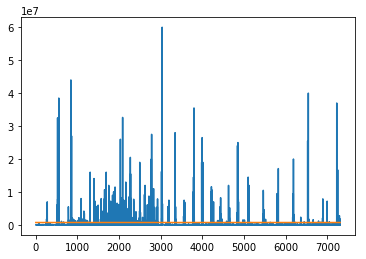

In [165]:
plt.plot(picasso[['hammer_price', 'auction_date']])

In [166]:
picasso[['auction_date']].head()

,auction_date
0,2008-10-02 09:30:00.553
1,2018-03-28 00:00:00.000
2,2009-10-29 14:00:00.000
3,2012-11-01 00:00:00.000
4,2011-09-27 09:30:00.464


In [167]:
picasso_with_forex.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth,Value,hammer_price_usd
count,7306.000000,7306.000000,7306.000000,7306.000000,7306.000000,7.306000e+03,7.306000e+03,7.306000e+03,7306.000000,7306.000000,7306.000000,4607.000000,4.607000e+03
mean,1607.068711,1879.454421,1971.378867,193.493019,64.113058,3.266596e+05,2.826244e+05,3.971199e+05,18.246485,17.633898,-0.465220,0.918193,4.021018e+05
std,732.924929,53.914643,56.550215,156.989101,78.028423,2.110564e+06,1.803110e+06,2.383100e+06,81.154769,79.458124,9.601592,0.147415,2.368429e+06
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000,-1.000000,-1.000000,0.504400,-1.685204e+00
25%,1925.000000,1881.000000,1973.000000,46.000000,-1.000000,4.200000e+03,3.500000e+03,5.000000e+03,-1.000000,-1.000000,-1.000000,0.940300,4.750000e+03
50%,1952.000000,1881.000000,1973.000000,179.000000,34.000000,9.000000e+03,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000,1.000000,9.767092e+03
75%,1960.000000,1881.000000,1973.000000,309.000000,118.000000,4.000000e+04,3.000000e+04,4.500000e+04,-1.000000,-1.000000,-1.000000,1.000000,4.200000e+04
max,2621.000000,1881.000000,1973.000000,990.000000,932.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000,1.000000,6.000000e+07


In [168]:
picasso_data = picasso_with_forex.loc[picasso_with_forex['hammer_price_usd'] > 0, :]

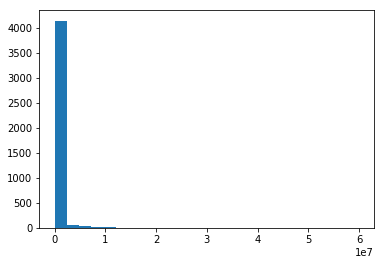

In [169]:
_ = plt.hist(picasso_data['hammer_price_usd'], bins=25)

In [170]:
# note that the spacing of the time series is uneven
np.sort(picasso_data['auction_date'].unique())

array(['2008-02-07T00:00:00.000000000', '2008-02-13T15:00:00.000000000',
       '2008-02-14T00:00:00.000000000', '2008-04-02T00:00:00.000000000',
       '2008-04-29T00:00:00.000000000', '2008-05-01T14:00:00.000000000',
       '2008-05-06T00:00:00.000000000', '2008-05-07T00:00:00.000000000',
       '2008-05-07T23:00:00.000000000', '2008-05-08T14:00:00.000000000',
       '2008-05-21T00:00:00.000000000', '2008-06-05T00:00:00.000000000',
       '2008-06-10T00:00:00.000000000', '2008-07-31T00:00:00.000000000',
       '2008-10-07T14:00:00.000000000', '2008-10-28T00:00:00.000000000',
       '2008-10-30T14:00:00.000000000', '2008-11-04T00:00:00.000000000',
       '2008-11-05T15:00:00.000000000', '2008-11-06T00:00:00.000000000',
       '2008-11-07T00:00:00.000000000', '2008-11-23T00:00:00.000000000',
       '2008-12-02T00:00:00.000000000', '2009-02-05T00:00:00.000000000',
       '2009-02-12T15:00:00.000000000', '2009-04-28T00:00:00.000000000',
       '2009-04-29T00:00:00.000000000', '2009-04-30

The problem here is that our time series data is not evenly spaced. Since many time series models rely on evenly spaced data (for lags, etc.), if I wanted to use one here, I would first have to interpolate the data and then resample at even intervals. However, this could introduce significant bias into the data, which is undesireable for modeling purposes. Given the uneven nature of the data, I am not inclined to use such a method. If I am to use a machine learning model here, there are some considerations that will need to be made. 

A time series model is generally of the form $x_t=ax_{t-1}+b$, meaning that the variable of interest has some kind of time dependency, i.e. its value is informed by previous values. To use a machine learning model with time series data, we must reformat the data to somehow incorporate information about this time dependency. There are two options I can see to do this. The first is to lag the data:  for a particular $y_t$, the features will be $X_{t-1}$ and $y_{t-1}$. This will create a dataset that features the time dependence that a time series attempts to model. The second method would be to encode the date data (here the feature "auction_date") as different features based on the year, month, and day of the date. This will introduce a time element into the feature space (much as how one would encode a categorical variable as a one hot vector). 

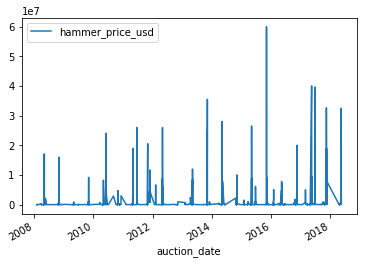

In [171]:
picasso_data.plot.line('auction_date', 'hammer_price_usd')

In [172]:
picasso_data = picasso_data.sort_values(['auction_date', 'nth_lot_in_auction'])
picasso_data.loc[:, 'auction_date':].head(n=5)

,auction_date,nth_lot_in_auction,lot_description,currency,hammer_price,estimate_low,estimate_high,height,width,depth,Date,Country,Value,hammer_price_usd
3731,2008-02-07,184,"PABLO PICASSO Le Saltimbanque au repos, from ...",USD,3500,3000,5000,448.0,324.0,-1.0,NaT,NaN,1.0,3500.0
3717,2008-02-07,185,PABLO PICASSO Nu assis entouré d'esquisses de...,USD,5500,3000,5000,-1.0,-1.0,-1.0,NaT,NaN,1.0,5500.0
3703,2008-02-07,186,PABLO PICASSO Colombe volant (B. 712; Mourlot...,USD,2200,1500,2500,-1.0,-1.0,-1.0,NaT,NaN,1.0,2200.0
3675,2008-02-07,187,PABLO PICASSO La famille du Saltimbanque (B. ...,USD,7500,6000,8000,502.0,654.0,-1.0,NaT,NaN,1.0,7500.0
3653,2008-02-07,188,"PABLO PICASSO Fernand Mourlot, Picasso lithog...",USD,1800,1500,2500,320.0,245.0,-1.0,NaT,NaN,1.0,1800.0


Examining the data, I note that there are multiple instances of auctions in a single day. There is also a variable 'nth_lot_in_auction', which gives us a sorted structure for the data. Reformatting the dataset as a lagged dataset as described above would help to mimic the nature of time series data, however given that the timesteps here are uneven, determining the proper lag introduces more complexity in the model. Given time constraints on this exercise, we proceed by incorporating time as features in the dataset. This gives us some ordering information in the dataset, which along with the 'nth_lot_in_auction' variable helps to introduce some temporal structure in the data. 

In [173]:
picasso_data['auction_year'] = pd.to_numeric(picasso_data['auction_date'].dt.year)
picasso_data['auction_month'] = pd.to_numeric(picasso_data['auction_date'].dt.month)
picasso_data['auction_day'] = pd.to_numeric(picasso_data['auction_date'].dt.day)

In [174]:
picasso_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4303 entries, 3731 to 7018
Data columns (total 31 columns):
work_title            4298 non-null object
medium                4303 non-null object
materials             4303 non-null object
submaterials          4303 non-null object
structure             4303 non-null object
date_of_execution     4303 non-null int64
artist                4303 non-null object
artist_nationality    4303 non-null object
artist_birth_year     4303 non-null int64
artist_death_year     4303 non-null int64
auction_sale_id       4303 non-null object
auction_house         4303 non-null object
auction_lot_count     4303 non-null int64
auction_location      4303 non-null object
auction_date          4303 non-null datetime64[ns]
nth_lot_in_auction    4303 non-null int64
lot_description       4303 non-null object
currency              4303 non-null object
hammer_price          4303 non-null int64
estimate_low          4303 non-null int64
estimate_high         4303 no

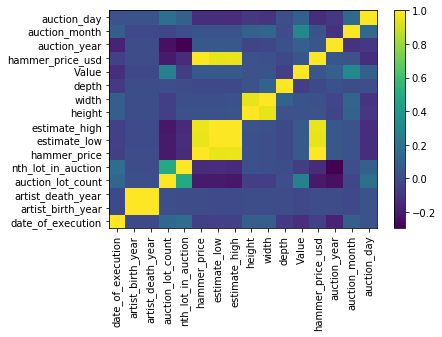

In [175]:
# now let's do some EDA to look at our variables
picasso_corr = picasso_data.corr()
plt.pcolor(picasso_corr)
plt.xticks(np.arange(0.5, len(picasso_corr.columns), 1), picasso_corr.columns, rotation='vertical')
plt.yticks(np.arange(0.5, len(picasso_corr.index), 1), picasso_corr.index)
plt.colorbar()
plt.figure(figsize=(50,50))
plt.show()

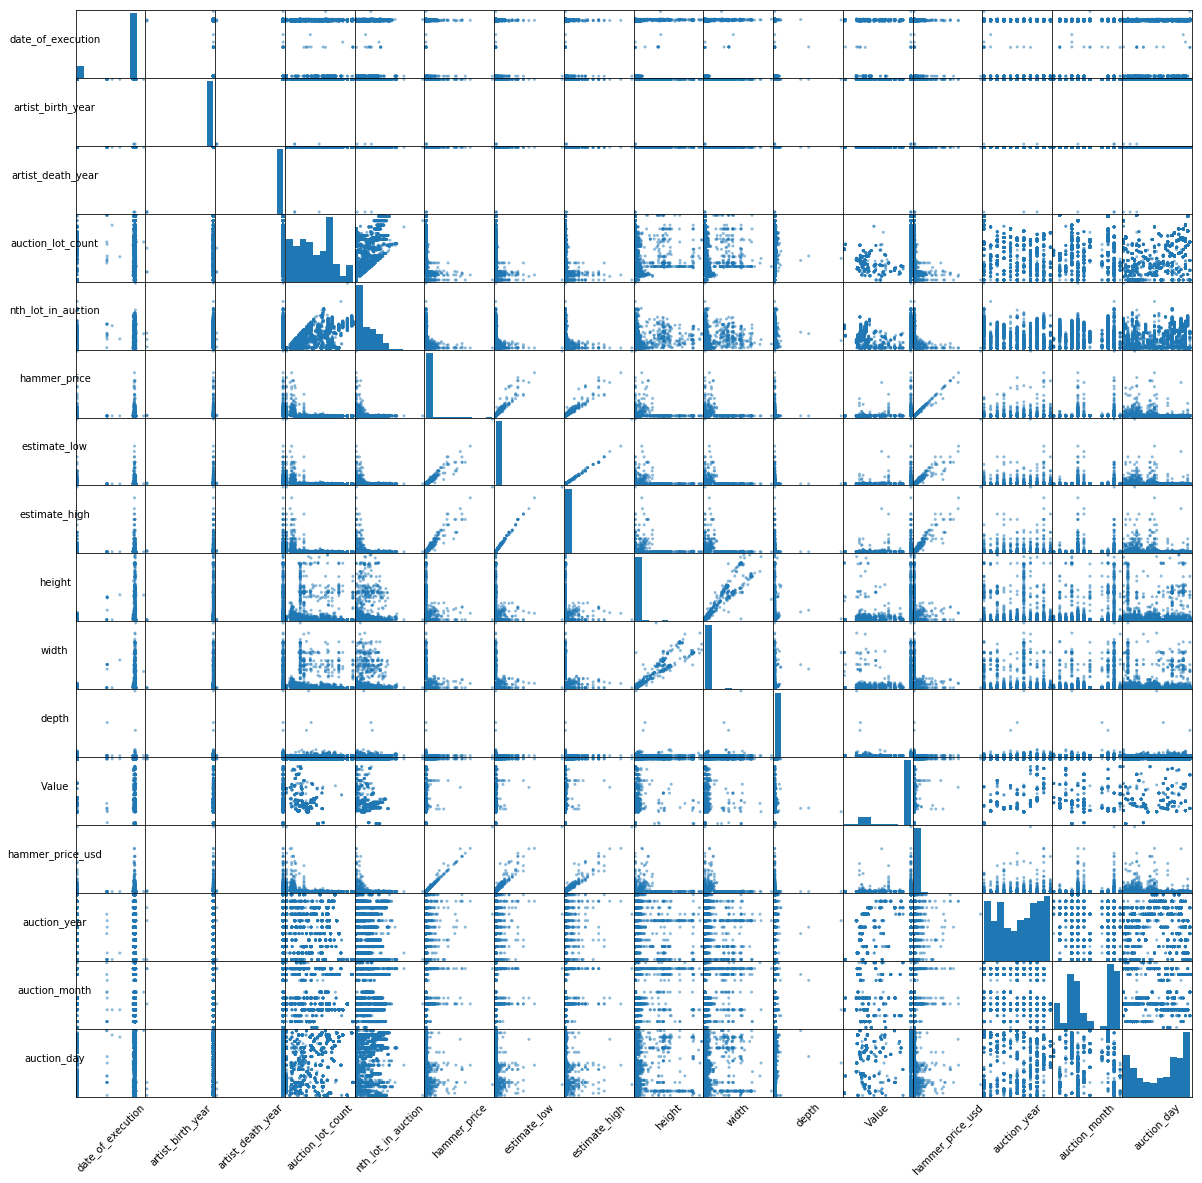

In [176]:
_ = pd.plotting.scatter_matrix(picasso_data, figsize=(20, 20))

# this formatting code taken from 
# https://stackoverflow.com/questions/32560932/how-to-customize-a-scatter-matrix-to-see-all-titles/32568134
v1 = [s.xaxis.label.set_rotation(45) for s in _.reshape(-1)]
v2 = [s.yaxis.label.set_rotation(0) for s in _.reshape(-1)]

# May need to offset label when rotating to prevent overlap of figure
v3 = [s.get_yaxis().set_label_coords(-0.3,0.5) for s in _.reshape(-1)]

# Hide all ticks
v4 = [s.set_xticks(()) for s in _.reshape(-1)]
v5 = [s.set_yticks(()) for s in _.reshape(-1)]

These two plots show that there aren't many obvious relationships in the data, aside from esimates and hammer prices. This suggests non-linearity in the data.

In [177]:
picasso_data.describe()

,date_of_execution,artist_birth_year,artist_death_year,auction_lot_count,nth_lot_in_auction,hammer_price,estimate_low,estimate_high,height,width,depth,Value,hammer_price_usd,auction_year,auction_month,auction_day
count,4303.000000,4303.000000,4303.000000,4303.000000,4303.000000,4.303000e+03,4.303000e+03,4.303000e+03,4303.000000,4303.000000,4303.000000,4303.000000,4.303000e+03,4303.000000,4303.000000,4303.000000
mean,1640.853126,1879.687892,1971.623751,239.655124,73.895189,4.101412e+05,3.407691e+05,4.849264e+05,26.112038,25.508634,-0.209691,0.913655,4.305097e+05,2012.742970,7.009296,17.605392
std,713.263855,49.681374,52.110007,152.529096,76.217079,2.351829e+06,1.980484e+06,2.673114e+06,94.314602,93.302303,12.370907,0.150215,2.448186e+06,3.120236,3.251993,10.156332
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,4.800000e+02,1.000000e+02,2.000000e+02,-1.000000,-1.000000,-1.000000,0.504400,5.000000e+02,2008.000000,1.000000,1.000000
25%,1933.000000,1881.000000,1973.000000,119.000000,-1.000000,5.000000e+03,4.000000e+03,6.000000e+03,-1.000000,-1.000000,-1.000000,0.878000,5.500000e+03,2010.000000,4.000000,7.000000
50%,1953.000000,1881.000000,1973.000000,235.000000,54.000000,1.000000e+04,8.000000e+03,1.200000e+04,-1.000000,-1.000000,-1.000000,1.000000,1.100000e+04,2013.000000,6.000000,21.000000
75%,1961.000000,1881.000000,1973.000000,361.000000,131.000000,4.500000e+04,3.000000e+04,5.000000e+04,-1.000000,-1.000000,-1.000000,1.000000,4.800000e+04,2016.000000,10.000000,27.000000
max,2250.000000,1881.000000,1973.000000,576.000000,527.000000,6.000000e+07,6.000000e+07,6.000000e+07,749.000000,924.000000,654.000000,1.000000,6.000000e+07,2018.000000,12.000000,31.000000


In [178]:
picasso_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4303 entries, 3731 to 7018
Data columns (total 31 columns):
work_title            4298 non-null object
medium                4303 non-null object
materials             4303 non-null object
submaterials          4303 non-null object
structure             4303 non-null object
date_of_execution     4303 non-null int64
artist                4303 non-null object
artist_nationality    4303 non-null object
artist_birth_year     4303 non-null int64
artist_death_year     4303 non-null int64
auction_sale_id       4303 non-null object
auction_house         4303 non-null object
auction_lot_count     4303 non-null int64
auction_location      4303 non-null object
auction_date          4303 non-null datetime64[ns]
nth_lot_in_auction    4303 non-null int64
lot_description       4303 non-null object
currency              4303 non-null object
hammer_price          4303 non-null int64
estimate_low          4303 non-null int64
estimate_high         4303 no

In [179]:
# given the above relationships plotted, I'm going to select the following numerical variables for the model
numerical_attr = ['date_of_execution', 'auction_lot_count', 'nth_lot_in_auction', 'estimate_low', 'estimate_high', 
                  'height', 'width', 'depth', 'auction_year', 'auction_month', 'auction_day']

# and these categorical attributes
categorical_attr = ['medium', 'materials', 'submaterials', 'structure', 'auction_house', 'auction_location']

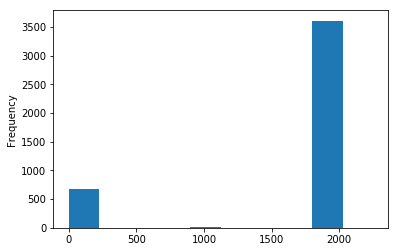

In [180]:
# further data cleaning

# I noticed that some values in the 'execution_date' column were weird, I want to see what the distribution of these values is
picasso_data['date_of_execution'].plot.hist()

In [181]:
# Some of these dates either do not exist or are wrong. Since most of the data seems to be in a reasonable time frame, 
# I will impute the entries less than 1881, the year Picasso was born, to the value nan
picasso_data.loc[picasso_data['date_of_execution'] < 1881, 'date_of_execution'] = np.nan

In [182]:
# several other of the numerical values have negative numbers, these will be changed to nan and imputed later
# these -1 values indicate that the value is missing
picasso_data[picasso_data[numerical_attr] < 0] = np.nan

In [183]:
# now I encode my one-hot vector
cat_encoded_df = pd.get_dummies(picasso_data[categorical_attr])
col_names = [c for c in cat_encoded_df.columns if c.lower()[-1] != '1']
cat_encoded_df = cat_encoded_df[col_names]
#picasso_data.drop(labels=categorical_attr, axis=1, inplace=True)
#picasso_data = picasso_data.join(cat_encoded_df)

In [184]:
num_df = picasso_data[numerical_attr]
total_data = num_df.join(cat_encoded_df)

In [185]:
# do divide into the train and data set, I will use 80% of the data for the train set
# as this is a time series problem, we cannot randomly sample our data for these sets
# the hold out set must be future data relative to the training data
train_index = int(0.8 * len(total_data))
train_data = total_data.iloc[:train_index, :]
test_data = total_data.iloc[train_index:, :]

In [186]:
# preparing data for modeling with pipelines
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy='median')),
    ('std_scaler', StandardScaler())
])

In [205]:
# extract labels from each dataset
train_target = picasso_data.iloc[:train_index, :]['hammer_price_usd']
test_target = picasso_data.iloc[train_index:, :]['hammer_price_usd']

In [189]:
processed_training_data = num_pipeline.fit_transform(train_data)

In [190]:
processed_test_data = num_pipeline.transform(test_data)

In [215]:
random_seed = 42

In [223]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor(n_estimators=500, random_state=random_seed)
random_forest.fit(processed_training_data, train_target)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
           oob_score=False, random_state=42, verbose=0, warm_start=False)

In [224]:
predictions = random_forest.predict(processed_test_data)

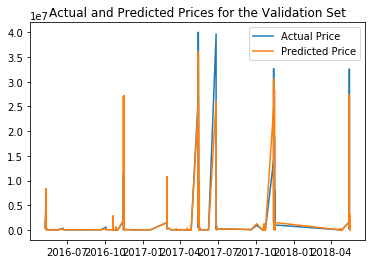

In [232]:
test_dates = picasso_data.iloc[train_index: , :]['auction_date']
plt.plot(test_dates, test_target, label='Actual Price')
plt.plot(test_dates, predictions, label='Predicted Price')
plt.title('Actual and Predicted Prices for the Validation Set')
plt.legend()
plt.show()

In [230]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
rms = sqrt(mean_squared_error(test_target, predictions))
mae = mean_absolute_error(test_target, predictions)

print('Root Mean Squared Error on Validation Set: {}'.format(rms))
print('Mean Absolute Error on Validation Set: {}'.format(mae))

Root Mean Squared Error on Validation Set: 1410676.478023825
Mean Absolute Error on Validation Set: 255438.42253035022


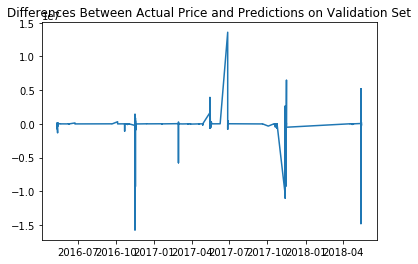

In [236]:
plt.plot(test_dates, test_target-predictions)
plt.title('Differences Between Actual Price and Predictions on Validation Set')
plt.show()

#### Discussion

From the plots above, we can see that the model with temporal information is able to approximate the price series in the validation set. I chose to use a random forest model, to handle the nonlinear relationships suggested by the data in the scatter matrix and correlation plots. The random forest is additionally a good base model to use as it has good empirical performance on a wide range of problems. Categorical variables were dummy encoded, and any variable with redundant information (such as artist, or birth year) were eliminated as they did not add any new information. Data was standardized to make data scales consistent. 